# Import

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sentence_transformers import SentenceTransformer
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import pickle
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder

# Load data

In [3]:
df = pd.read_csv(r"C:\Users\leege\Documents\Capstone\elderly_topical_conversational_sentences.csv")

df['label'].value_counts()

label
short-term    2817
long-term     2213
healthcare    2109
Name: count, dtype: int64

# Feature Extraction

In [4]:
import pandas as pd
import re

HEALTHCARE_KEYWORDS = [
    "clinic", "polyclinic", "hospital", "doctor", "nurse", "medicine",
    "tablet", "capsule", "injection", "pain", "ache", "symptom",
    "treatment", "checkup", "appointment", "blood pressure", "diabetes",
    "cholesterol", "physiotherapy", "rehabilitation", "pharmacy", "scan",
    "surgery", "therapy", "consultation", "vaccination", "prescription"
]

LONGTERM_KEYWORDS = [
    "grandson", "granddaughter", "children", "family", "siblings", "parents",
    "hobby", "gardening", "reading", "knitting", "painting", "cooking",
    "house", "flat", "HDB", "condo", "car", "pet", "cat", "dog",
    "garden", "relatives", "friends", "community", "club", "volunteer",
    "retirement", "savings", "pension"
]

SHORTTERM_KEYWORDS = [
    "today", "tomorrow", "later", "now", "yesterday", "tonight",
    "MRT", "bus", "train", "hawker", "hawker centre", "kopitiam",
    "wet market", "supermarket", "shop", "shopping", "meal", "breakfast",
    "lunch", "dinner", "snack", "queue", "appointment", "errand", "weather",
    "rain", "sunny", "hot", "cold", "event", "celebration", "CNY", "angbao",
    "getai", "festival", "promotion", "sale", "traffic", "delay", "jam"
]

def count_category_words(text, category_words):
    """Count how many words in `text` match `category_words` (case-insensitive)."""
    words = re.findall(r'\b\w+\b', text.lower())
    return sum(1 for w in words if w in category_words)

def add_category_word_counts(df):
    df = df.copy()  # Avoid modifying original df
    df['healthcare_count'] = df['text'].apply(lambda x: count_category_words(x, HEALTHCARE_KEYWORDS))
    df['longterm_count'] = df['text'].apply(lambda x: count_category_words(x, LONGTERM_KEYWORDS))
    df['shortterm_count'] = df['text'].apply(lambda x: count_category_words(x, SHORTTERM_KEYWORDS))
    return df

df = add_category_word_counts(df)
df

,text,label,healthcare_count,longterm_count,shortterm_count
0,I need to collect my blood pressure medicine f...,healthcare,2,0,1
1,My knee has been aching a bit more since the r...,healthcare,0,0,1
2,Did you remember to take your diabetes pills a...,healthcare,1,0,1
3,The doctor at the CHAS clinic told me to reduc...,healthcare,2,0,0
4,I have a physiotherapy appointment next Tuesda...,healthcare,2,0,1
...,...,...,...,...,...
7134,Let's have some Hokkien mee for lunch.,short-term,0,0,1
7135,My daughter just got a new job in a multinatio...,long-term,0,0,0
7136,The new community garden is so beautiful and w...,short-term,0,2,0
7137,My husband and I have been visiting the same h...,long-term,0,0,1


In [5]:
from dotenv import load_dotenv
import os

load_dotenv() 
huggingface_token = os.getenv("HUGGINGFACE_TOKEN")

In [ ]:
# Feature Extraction with tf-idf
X_text = df['text'].values
y_text = df['label'].values

# Encode text labels to integers
le = LabelEncoder()
y = le.fit_transform(y_text)
print("Label mapping:", dict(zip(le.classes_, range(len(le.classes_)))))

# TF-IDF features
tfidf_vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1,2))
X_tfidf = tfidf_vectorizer.fit_transform(X_text).toarray()

# SBERT embeddings
# all-MiniLM-L6-v2 or all-mpnet-base-v2
sbert_model = SentenceTransformer('google/embeddinggemma-300m')
X_sbert = sbert_model.encode(X_text, show_progress_bar=True)

# Categorical features
category_features = df[['healthcare_count', 'longterm_count', 'shortterm_count']].values

# Combine all features
X_hybrid = np.hstack([X_tfidf, X_sbert, category_features])
print("Hybrid feature shape:", X_hybrid.shape)

label_names = le.classes_
y_ova = {}
for label_name in label_names:
    y_ova[label_name] = (y_text == label_name).astype(int)

Label mapping: {'healthcare': 0, 'long-term': 1, 'short-term': 2}


Batches:   0%|          | 0/224 [00:00<?, ?it/s]

Hybrid feature shape: (7139, 1271)


# Training


Training One-vs-All model for label: healthcare
Validation Accuracy for healthcare: 0.9755
Classification Report:
               precision    recall  f1-score   support

           0       0.97      0.99      0.98      1006
           1       0.98      0.94      0.96       422

    accuracy                           0.98      1428
   macro avg       0.98      0.96      0.97      1428
weighted avg       0.98      0.98      0.98      1428



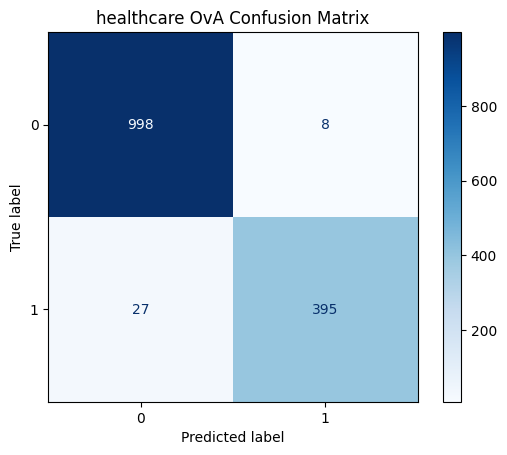


Training One-vs-All model for label: long-term
Validation Accuracy for long-term: 0.9783
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.98      0.98       985
           1       0.96      0.97      0.97       443

    accuracy                           0.98      1428
   macro avg       0.97      0.98      0.97      1428
weighted avg       0.98      0.98      0.98      1428



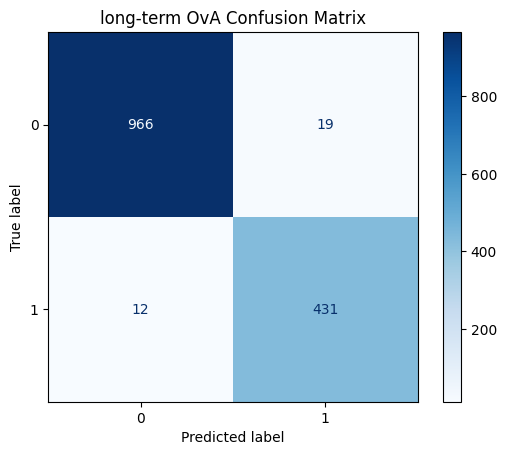


Training One-vs-All model for label: short-term
Validation Accuracy for short-term: 0.9671
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       864
           1       0.97      0.94      0.96       564

    accuracy                           0.97      1428
   macro avg       0.97      0.96      0.97      1428
weighted avg       0.97      0.97      0.97      1428



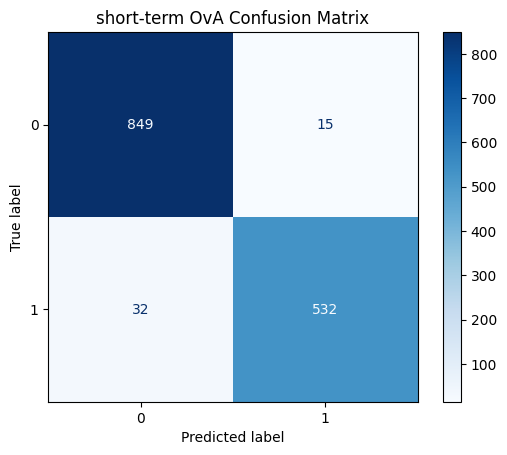

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# List of label names
label_names = list(y_ova.keys())

# Dictionary to store models and evaluation results
models_ova = {}
results_ova = {}

for label_name in label_names:
    print(f"\nTraining One-vs-All model for label: {label_name}")
    
    # Use the OvA target
    y_binary = y_ova[label_name]
    
    # Train/Validation/Test Split
    X_trainval, X_test, y_trainval, y_test = train_test_split(
        X_hybrid, y_binary, test_size=0.2, random_state=42, stratify=y_binary
    )
    X_train, X_val, y_train, y_val = train_test_split(
        X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
    )
    
    # Logistic Regression (OvA)
    log_reg = LogisticRegression(
        C=1.0,
        penalty="l2",
        solver="lbfgs",
        max_iter=2000,
        random_state=42
    )
    
    log_reg.fit(X_train, y_train)
    models_ova[label_name] = log_reg
    
    # Validation performance
    y_pred_val = log_reg.predict(X_val)
    acc = accuracy_score(y_val, y_pred_val)
    print(f"Validation Accuracy for {label_name}: {acc:.4f}")
    print("Classification Report:\n", classification_report(y_val, y_pred_val))
    
    # Optional: plot confusion matrix
    cm = confusion_matrix(y_val, y_pred_val)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0,1])
    disp.plot(cmap=plt.cm.Blues)
    plt.title(f"{label_name} OvA Confusion Matrix")
    plt.show()


# Test case

In [18]:
def predict_text_multilabel(new_texts, models_ova):
    """
    Input:
        new_texts: list of strings
        models_ova: dict of trained OvA models {'healthcare': clf, ...}
    Output:
        list of lists, each inner list contains all predicted labels for the text
    """
    # TF-IDF and SBERT
    X_tfidf_new = tfidf_vectorizer.transform(new_texts).toarray()
    X_sbert_new = sbert_model.encode(new_texts, show_progress_bar=False)
    
    # Category word counts
    category_features_new = np.array([
        [
            count_category_words(t, HEALTHCARE_KEYWORDS),
            count_category_words(t, LONGTERM_KEYWORDS),
            count_category_words(t, SHORTTERM_KEYWORDS)
        ]
        for t in new_texts
    ])
    
    # Combine all features
    X_new_hybrid = np.hstack([X_tfidf_new, X_sbert_new, category_features_new])
    
    label_names = list(models_ova.keys())
    predictions = []
    
    # Run each model independently
    for i in range(X_new_hybrid.shape[0]):
        text_labels = []
        for label_name in label_names:
            clf = models_ova[label_name]
            pred = clf.predict(X_new_hybrid[i].reshape(1, -1))[0]
            if pred == 1:
                text_labels.append(label_name)
        predictions.append(text_labels)
    
    return predictions

# Example usage
predict_text_multilabel([
    "Forget eat medicine again", 
    "Go shopping tomorrow", 
    "Visit grandma today",
    "I have one brother"
], models_ova)


[['healthcare'], ['short-term'], ['short-term'], ['long-term']]

# Save model (Change directory accordingly)

In [19]:
# Save models
for label_name, clf in models_ova.items():
    path = f"../model_weights/log_reg_ova_{label_name}.pkl"
    with open(path, "wb") as f:
        pickle.dump(clf, f)
with open("../model_weights/topic_tfidf_vectorizer.pkl", "wb") as f:
    pickle.dump(tfidf_vectorizer, f)

with open("../model_weights/topic_sbert_model_name.pkl", "wb") as f:
    pickle.dump('google/embeddinggemma-300m', f)

with open('../model_weights/topic_label_encoder.pkl', 'wb') as f:
    pickle.dump(le, f)
    
with open('../model_weights/topic_category_keywords.pkl', 'wb') as f:
    pickle.dump({
        'healthcare': HEALTHCARE_KEYWORDS,
        'longterm': LONGTERM_KEYWORDS,
        'shortterm': SHORTTERM_KEYWORDS
    }, f)

print("Models and artifacts saved.")


Models and artifacts saved.


# Randomized Search - Hyperparameter tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score

param_dist = {
    'n_estimators': randint(100, 600),
    'max_depth': randint(3, 10),
    'learning_rate': uniform(0.01, 0.2),
    'min_child_weight': randint(1, 6),
    'gamma': uniform(0, 0.5),
    'subsample': uniform(0.6, 0.4),
    'colsample_bytree': uniform(0.6, 0.4),
    'reg_alpha': uniform(0, 0.5),
    'reg_lambda': uniform(0.5, 2)
}

xgb_model = XGBClassifier(
    objective='multi:softprob',  # multi-class
    num_class=3,
    eval_metric='mlogloss',
    random_state=42
)

random_search = RandomizedSearchCV(
    estimator=xgb_model,
    param_distributions=param_dist,
    n_iter=15,
    scoring='accuracy',
    cv=3,
    verbose=2,
    n_jobs=-1,
    random_state=42
)

# Fit
random_search.fit(X_train, y_train)

# Score
print("Best parameters found:", random_search.best_params_)
print("Best CV accuracy:", random_search.best_score_)

# Eval
best_model = random_search.best_estimator_
y_pred = best_model.predict(X_test)
print("Test accuracy:", accuracy_score(y_test, y_pred))

# Benchmark speed and results against other models

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
import pandas as pd
import pickle
import os
import time
from collections import OrderedDict

# -----------------------
# Train/Validation/Test Split
# -----------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# -----------------------
# Baseline Models
# -----------------------
models = OrderedDict()

# Add the stacked model first
estimators = [
    ('lgbm', LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0)),
    ('lr_base', LogisticRegression(max_iter=500, solver='lbfgs', random_state=42))
]

stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)

models['Stacked_LGBM_XGB_LR'] = stacked_model

# Then add the rest of the baseline models
models.update({
    "LightGBM": LGBMClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42, verbose=-1),
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, solver="lbfgs", random_state=42),
    "SVM": SVC(kernel="linear", C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=42, verbosity=0)
})

# -----------------------
# Train, Evaluate, Measure Size & Time
# -----------------------
all_reports = {}
size_dict = {}
time_dict = {}

for name, model in models.items():
    # Train
    start_train = time.time()
    model.fit(X_train, y_train)
    end_train = time.time()
    
    # Predict on validation
    start_pred = time.time()
    y_val_pred = model.predict(X_val)
    end_pred = time.time()
    
    # Accuracy & report
    acc = accuracy_score(y_val, y_val_pred)
    print(f"{name} Validation Accuracy: {acc:.4f}")
    
    report = classification_report(y_val, y_val_pred, output_dict=True)
    all_reports[name] = report
    
    print(f"\nClassification Report for {name}:")
    print(classification_report(y_val, y_val_pred))
    
    # Measure size by saving temporarily with pickle
    tmp_file = f"tmp_{name}.pkl"
    with open(tmp_file, "wb") as f:
        pickle.dump(model, f)
    size_mb = os.path.getsize(tmp_file) / (1024 * 1024)
    size_dict[name] = size_mb
    os.remove(tmp_file)
    
    # Inference time per sample (on validation set)
    inference_time_per_sample = (end_pred - start_pred) / len(X_val)
    time_dict[name] = inference_time_per_sample
    
    print(f"{name} Model Size: {size_mb:.2f} MB")
    print(f"{name} Inference Time per Sample: {inference_time_per_sample:.6f} sec\n")

# -----------------------
# Macro-Averaged Comparison
# -----------------------
df_reports = pd.DataFrame({model: all_reports[model]["macro avg"] 
                           for model in all_reports}).T
df_reports = df_reports[["precision", "recall", "f1-score", "support"]]

# Add model size and inference time
df_reports["model_size_MB"] = pd.Series(size_dict)
df_reports["inference_time_sec"] = pd.Series(time_dict)

print("\n\n====== Macro-Averaged Comparison Across Baseline Models ======")
display(df_reports)


healthcare OvA F1-score: 0.9699, Model Size: 0.01 MB, Inference Time: 0.000002 sec
long-term OvA F1-score: 0.9717, Model Size: 0.01 MB, Inference Time: 0.000005 sec
short-term OvA F1-score: 0.9612, Model Size: 0.01 MB, Inference Time: 0.000003 sec

====== OvA Benchmarking Summary ======


,f1_score,model_size_MB,inference_time_sec
healthcare,0.969916,0.010345,0.000002
long-term,0.971687,0.010345,0.000005
short-term,0.961226,0.010345,0.000003
average,0.967610,0.010345,0.000003


In [24]:
import time
import os
import pickle
import pandas as pd
from collections import OrderedDict
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

# -----------------------
# Train/Validation/Test Split
# -----------------------
X_trainval, X_test, y_trainval, y_test = train_test_split(
    X_hybrid, y, test_size=0.2, random_state=42, stratify=y
)
X_train, X_val, y_train, y_val = train_test_split(
    X_trainval, y_trainval, test_size=0.25, random_state=42, stratify=y_trainval
)

# -----------------------
# Baseline Models
# -----------------------
models = OrderedDict()

# Stacked model
estimators = [
    ('RandomForest', RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42)),
    ('xgb', XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1,
                          use_label_encoder=False, eval_metric='mlogloss', random_state=42, verbosity=0)),
    ('lr_base', LogisticRegression(max_iter=500, solver='lbfgs', random_state=42))
]
stacked_model = StackingClassifier(
    estimators=estimators,
    final_estimator=LogisticRegression(max_iter=500, solver='lbfgs', random_state=42),
    cv=5,
    n_jobs=-1,
    passthrough=True
)
# models['Stacked_Model'] = stacked_model

# Other baseline models
models.update({
    "RandomForest": RandomForestClassifier(n_estimators=50, max_depth=5, random_state=42),
    "GradientBoosting": GradientBoostingClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, random_state=42),
    "LogisticRegression": LogisticRegression(max_iter=500, solver="lbfgs", random_state=42),
    # "SVM": SVC(kernel="linear", C=1.0, probability=True, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "NaiveBayes": GaussianNB(),
    "XGBoost": XGBClassifier(n_estimators=50, max_depth=3, learning_rate=0.1, use_label_encoder=False,
                             eval_metric='mlogloss', random_state=42, verbosity=0)
})

# -----------------------
# OvA label setup
# -----------------------
ova_labels = ['healthcare', 'long-term', 'short-term']
y_train_ova = {label: (y_train == idx).astype(int) for idx, label in enumerate(ova_labels)}
y_val_ova   = {label: (y_val   == idx).astype(int) for idx, label in enumerate(ova_labels)}

# -----------------------
# Train & Benchmark All Models in OvA
# -----------------------
results_list = []

for name, model_cls in models.items():
    f1_scores = []
    sizes = []
    times = []

    for label in ova_labels:
        # Clone a fresh model instance per label
        model = pickle.loads(pickle.dumps(model_cls))  # ensures fresh untrained instance

        # Train
        start_train = time.time()
        model.fit(X_train, y_train_ova[label])
        end_train = time.time()

        # Predict
        start_pred = time.time()
        y_pred = model.predict(X_val)
        end_pred = time.time()

        # F1-score
        f1 = f1_score(y_val_ova[label], y_pred)
        f1_scores.append(f1)

        # Model size
        tmp_file = f"tmp_{name}_{label}.pkl"
        with open(tmp_file, "wb") as f:
            pickle.dump(model, f)
        size_mb = os.path.getsize(tmp_file) / (1024 * 1024)
        sizes.append(size_mb)
        os.remove(tmp_file)

        # Inference time per sample
        inference_time_sec = (end_pred - start_pred) / len(X_val)
        times.append(inference_time_sec)

    # Append results
    results_list.append({
        "model": name,
        **{f"f1_{label}": f for label, f in zip(ova_labels, f1_scores)},
        "avg_f1": sum(f1_scores)/len(f1_scores),
        "avg_model_size_MB": sum(sizes)/len(sizes),
        "avg_inference_time_sec": sum(times)/len(times)
    })

# -----------------------
# Final DataFrame
# -----------------------
df_summary = pd.DataFrame(results_list)
df_summary = df_summary.sort_values("avg_f1", ascending=False)
print("\n====== OvA Baseline Model Benchmarking ======")
display(df_summary)



====== OvA Baseline Model Benchmarking ======


,model,f1_healthcare,f1_long-term,f1_short-term,avg_f1,avg_model_size_MB,avg_inference_time_sec
2,LogisticRegression,0.969916,0.971687,0.961226,0.967610,0.010345,0.000003
3,KNN,0.938480,0.950226,0.928255,0.938987,41.565430,0.000182
1,GradientBoosting,0.942892,0.925581,0.929476,0.932650,0.067302,0.000011
5,XGBoost,0.942189,0.917840,0.923216,0.927749,0.059621,0.000012
0,RandomForest,0.880105,0.849176,0.907547,0.878943,0.239846,0.000026
4,NaiveBayes,0.831325,0.878543,0.884244,0.864704,0.039339,0.000047


In [22]:
# Drop 'support' column
df_reports = df_reports.drop(columns=['support'])

# Reset general float display
pd.reset_option('display.float_format')

# Format only inference_time_sec
styled_df = df_reports.style.format({
    'inference_time_sec': '{:.2e}'
})

# Display the styled DataFrame
display(styled_df)


,precision,recall,f1-score,model_size_MB,inference_time_sec
Stacked_LGBM_XGB_LR,0.974471,0.974441,0.974455,0.494797,5.49e-05
LightGBM,0.949420,0.947974,0.948663,0.209438,9.96e-06
RandomForest,0.919582,0.908553,0.912964,0.276498,1.88e-05
GradientBoosting,0.953380,0.952209,0.952774,0.192527,3.22e-05
LogisticRegression,0.975301,0.975394,0.975342,0.029757,4.91e-06
SVM,0.980680,0.980484,0.980581,8.366755,7.05e-04
KNN,0.939005,0.938370,0.938610,41.565434,1.64e-04
NaiveBayes,0.916001,0.923565,0.917713,0.058752,6.73e-05
XGBoost,0.943614,0.941768,0.942642,0.170584,7.35e-06


In [29]:
from langgraph.graph import StateGraph, START, END
from pydantic import BaseModel
from typing import TypedDict, Literal, Optional, List
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain.schema import HumanMessage
import os, re
from dotenv import load_dotenv
class ClassificationState(TypedDict):
    text: str
    flow_type: Literal["online", "offline"]
    qa: Optional[str]
    topic: Optional[List[str]]  # now multi-label

graph = StateGraph(ClassificationState)
def qa_node():
    return "dd"
def topic_node():
    return "dd"
def llm_node():
    return "dd"
graph.add_node("QAClassifier", qa_node)
graph.add_node("TopicClassifier", topic_node)
graph.add_node("LLMClassifier", llm_node)

# Conditional branch from START
def choose_flow(state: ClassificationState):
    if state["flow_type"] == "online":
        return "LLMClassifier"
    elif state["flow_type"] == "offline":
        return "QAClassifier"
    else:
        raise ValueError(f"Invalid flow_type, please select offline or online: {state['flow_type']}")

graph.add_conditional_edges(
    START,
    choose_flow,
    {
        "LLMClassifier": "LLMClassifier",
        "QAClassifier": "QAClassifier"
    }
)

# Offline flow chain
graph.add_edge("QAClassifier", "TopicClassifier")
graph.add_edge("TopicClassifier", END)

# LLM flow ends directly
graph.add_edge("LLMClassifier", END)

# Compile
app = graph.compile()


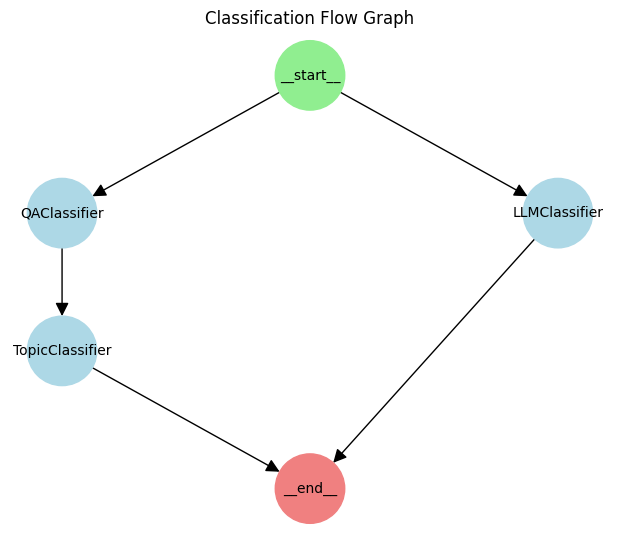

In [34]:
import networkx as nx
import matplotlib.pyplot as plt
from langgraph.graph import START, END

# Create directed graph
G = nx.DiGraph()

# Add nodes
nodes = [str(START), "QAClassifier", "TopicClassifier", "LLMClassifier", str(END)]
G.add_nodes_from(nodes)

# Add edges
edges = [
    (str(START), "LLMClassifier"),
    (str(START), "QAClassifier"),
    ("QAClassifier", "TopicClassifier"),
    ("TopicClassifier", str(END)),
    ("LLMClassifier", str(END))
]
G.add_edges_from(edges)

# Set positions for a top-down layout
pos = {
    str(START): (0, 4),
    "LLMClassifier": (1, 3),
    "QAClassifier": (-1, 3),
    "TopicClassifier": (-1, 2),
    str(END): (0, 1)
}

# Node colors
colors = ["lightgreen" if n == str(START) else "lightcoral" if n == str(END) else "lightblue" for n in G.nodes]

# Draw
plt.figure(figsize=(6, 5))
nx.draw(G, pos, with_labels=True, node_color=colors, node_size=2500, arrowsize=20, font_size=10)
plt.title("Classification Flow Graph", fontsize=12)
plt.axis("off")
plt.show()
